In [1]:
from src.common import data_utils
from src.training_methods.laplace import collate

In [2]:
data_path = "/home/joao/auger/codes/data/processed"

In [3]:
train_loader, val_loader, test_loader, (image_C, image_H, image_W) = (
        data_utils.get_data_loaders(
            data_path = data_path,
            batch_size = 256,
            num_workers = 15,
            num_classes = 2,
            return_dimensions=True,
            return_tuple=True,
            collate_fn = collate.custom_collate_fn,
        )
    )

## Laplace

In [2]:
import os
import sys
import time
import torch
import argparse
import numpy as np
import torch.nn as nn
import torch.backends.cudnn as cudnn

from laplace import Laplace
from src.training_methods.laplace import model as models
from src.training_methods.laplace import collate
from src.training_methods.laplace import train_utils
from src.common import data_utils
from src.common import print_utils
from src.common import base_saver

from src.common.base_saver import check_for_exps_folders

In [3]:
run_filepath = '/home/joao/auger/networks/laplace_run01'

In [4]:
train_loader, val_loader, test_loader, (image_C ,image_H, image_W) = data_utils.get_data_loaders(
        data_path = "/home/joao/auger/data/processed", batch_size = 256, 
        num_workers = 15, num_classes = 2, 
        return_dimensions = True, return_tuple = True,
        collate_fn = collate.custom_collate_fn
    )

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
model = models.laplace_model(
    C_in = image_C,
    C = 6,
    H_in = image_H,
    W_in = image_W,
    num_classes = 2,
).to(device)

In [ ]:
path = os.path.join(run_filepath, "model_best.pt")
dict = torch.load(path, weights_only=False)
model.load_state_dict(dict["model_state_dict"])

<All keys matched successfully>

In [8]:
la = Laplace(model, 'classification',
                 subset_of_weights='last_layer',
                 hessian_structure='full'
                )
la.fit(train_loader)

la.optimize_prior_precision(method="gridsearch",
                            pred_type="glm",
                            link_approx="mc",
                            val_loader=val_loader
                            )

/home/joao/miniconda3/envs/pytorch/lib/python3.13/site-packages/torch/autograd/graph.py:824: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:181.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/joao/miniconda3/envs/pytorch/lib/python3.13/site-packages/laplace/baselaplace.py:435: UserWarning: By default `link_approx` is `probit`. Make sure to set it equals to the way you want to call `la(test_data, pred_type=..., link_approx=...)`.
  warnings.warn(


In [9]:
predictions = []
targets = []
for x, y in test_loader:
    x = x.to(device=device)
    y = y.to(device=device)
    predictions.append(la.predictive_samples(x, pred_type="glm", n_samples=10000))
    targets.append(y)


In [10]:
samples = torch.cat(predictions, dim = 1)
targets = torch.cat(targets)

In [11]:
from src.training_methods.laplace.metric_utils import laplace_metric

In [12]:
la_metric = laplace_metric(device)

In [13]:
laplace_results = la_metric.get_metrics(samples = samples, target= targets)

## Ensemble

In [17]:
import os
import sys
import time
import copy
import torch
import argparse

import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn

from ensemble import save_utils
from ensemble import train_utils
from conventional import data_utils
from conventional import print_utils
from conventional.models import Network
from torch.func import stack_module_state
from torch.utils.tensorboard import SummaryWriter
import torch.nn.functional as F

In [18]:
run_filepath = "/home/joao/auger/networks/ensemble_run01"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_models = 10

In [19]:
train_loader, val_loader, test_loader, (image_C ,image_H, image_W) = data_utils.get_data_loaders(
    data_path = "/home/joao/auger/dataset/splited", batch_size = 256, 
    num_workers = 15, num_classes = 2, 
    return_dimensions = True
)

In [20]:
model_list = [
    Network(
        C_in = image_C,
        C = 6,
        H_in = image_H,
        W_in = image_W,
        num_classes = 2,
    ).to(device) for _ in range(num_models)
]
base_model = copy.deepcopy(model_list[0])
base_model = base_model.to(device)
criterion = nn.CrossEntropyLoss()
criterion = criterion.to(device)

In [21]:
model_list = save_utils.load_ensemble_models(run_filepath, model_list)
params, buffers = stack_module_state(model_list)
trainer = train_utils.ensemble_trainer(device, num_models, params, buffers)
targets, outputs, ids = trainer.evaluate(base_model, test_loader, criterion, 0, return_outputs = True)
probs = F.softmax(outputs.mean(dim=0), dim=1)
individual_probs = F.softmax(outputs, dim=2)

/home/joao/miniconda3/envs/pytorch/lib/python3.13/site-packages/rich/live.py:231: UserWarning: install "ipywidgets"
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [22]:
from ensemble.metric_utils import ensemble_metric

In [23]:
e_metric = ensemble_metric(device=device)

In [24]:
ensemble_results = e_metric.get_metrics(probs, individual_probs, ids, targets)

## Posterior

In [25]:
import os
import sys
import time
import torch
import argparse

import numpy as np
import torch.optim as optim
import torch.backends.cudnn as cudnn

from posterior.PosteriorNetwork import PosteriorNetwork
from conventional import save_utils
from posterior import train_utils
from conventional import data_utils
from conventional import print_utils
from torch.utils.tensorboard import SummaryWriter

/home/joao/miniconda3/envs/pytorch/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [26]:
run_filepath = "/home/joao/auger/networks/posterior_run02"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [27]:
train_loader, val_loader, test_loader, (image_C ,image_H, image_W), N  = data_utils.get_data_loaders(
    data_path = "/home/joao/auger/dataset/splited", batch_size = 256, 
    num_workers = 15, num_classes = 2, 
    return_dimensions = True, return_class_counts = True
)

In [28]:
model = PosteriorNetwork(
        N = N,                      # Count of data from each class in training set.
        C_in = image_C,             # Input channel dimension.
        H_in = image_H,             # Input height
        W_in = image_W,             # Input width
        C = 6,                      # Hidden channel dimension
        output_dim = 2,             # Output dimension. int
        latent_dim = 4,             # Latent dimension. int
        n_density = 4,              # Number of density components. int
        seed = 123                  # Random seed
    ).to(device)

criterion = train_utils.UCE_loss
post_trainer = train_utils.posterior_trainer(device, 2, 1e-5)

In [29]:
path = os.path.join(run_filepath, f"model_best.pt")
dict = torch.load(path, weights_only=False)
model.load_state_dict(dict["model_state_dict"])

targets, alphas, probs, ids = post_trainer.evaluate(model, test_loader, criterion, 0, return_outputs = True)

alphas_dict = {
        'ids': ids,
        'alphas': alphas,
        'probs': probs,
        'targets': targets,
    }

In [30]:
from posterior.metric_utils import posterior_metric

In [31]:
post_metric = posterior_metric(device)

In [32]:
post_results = post_metric.get_metrics(alphas, ids, targets)

# Prints

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from typing import List, Tuple, Optional

In [112]:
def plot_multi_reliability_diagram(
    all_probabilities: List[torch.Tensor],
    all_predictions_correct: List[torch.Tensor],
    model_names: List[str],
    colors: List[str],
    alpha: float,
    n_bins: int = 20,
    title: str = "Diagrama Confiabilidade",
    figsize: Tuple[int, int] = (10, 6),
    save_path: Optional[str] = None,
    fontsize: int = 18
) -> None:
    """
    Plots a comparative reliability diagram for multiple models.

    Args:
        all_probabilities: A list of torch.Tensors of predicted probabilities for each model.
        all_predictions_correct: A list of torch.Tensors of binary flags indicating correct predictions.
        model_names: A list of strings with names for each model for the legend.
        n_bins: The number of bins to use for the diagram.
        title: The title for the plot.
        figsize: The figure size as a tuple (width, height).
    """
    # Convert torch tensors to numpy arrays
    numpy_probs = [p.detach().cpu().numpy() for p in all_probabilities]
    numpy_preds_correct = [pc.detach().cpu().numpy() for pc in all_predictions_correct]

    # Create bins
    bin_boundaries = np.linspace(0, 1, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    
    num_models = len(model_names)
    all_bin_accuracies = [[] for _ in range(num_models)]

    # Calculate statistics for each model
    for i in range(num_models):
        probabilities = numpy_probs[i]
        predictions_correct = numpy_preds_correct[i]
        
        for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
            in_bin = (probabilities > bin_lower) & (probabilities <= bin_upper)
            
            if np.sum(in_bin) > 0:
                bin_accuracy = np.mean(predictions_correct[in_bin])
            else:
                bin_accuracy = 0
                
            all_bin_accuracies[i].append(bin_accuracy)

    # Create the plot
    fig= plt.figure(figsize=figsize)
    ax1 = fig.add_subplot(111)
    
    # --- Main reliability diagram (ax1) ---
    ax1.plot([0, 1], [0, 1], 'k--', alpha=0.7, label='Calibração Perfeita')
    
    # Bar plot settings
    bin_centers = (bin_lowers + bin_uppers) / 2
    total_bar_width = 0.8 * (1.0 / n_bins)
    individual_bar_width = total_bar_width / num_models

    # Plot grouped bars for each model
    for i in range(num_models):
        offset = (i - num_models / 2 + 0.5) * individual_bar_width
        ax1.bar(
            bin_centers + offset,
            all_bin_accuracies[i],
            width=individual_bar_width,
            color=colors[i],
            alpha=alpha,
            edgecolor='black',
            linewidth=0.5,
            label=model_names[i]
        )

    ax1.set_xticks(bin_boundaries[::2])
    ax1.set_xticklabels([f'{x:.2f}' for x in bin_boundaries[::2]], rotation=45, ha='right')
    ax1.set_xticks(bin_boundaries[1::2], minor=True)
    

    ax1.set_xlabel('Confiança média', fontsize=fontsize+3)
    ax1.set_ylabel('Acurácia', fontsize=fontsize+3)
    ax1.set_title(title, fontsize=fontsize+4)
    ax1.legend(fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    ax1.grid(True, alpha=0.3)
    
    ax1.set_xlim(0, 1)
    ax1.set_ylim(0, 1)
    
    

    plt.tight_layout()
    plt.savefig(save_path+ "/ECE.pdf", dpi = 150, format = "pdf") if save_path else None
    plt.show()



In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from typing import Tuple, Optional, List, Dict, Any

def plot_multi_roc_curve(
    all_probabilities: List[np.ndarray],
    all_predictions_correct: List[np.ndarray],
    model_names: List[str],
    colors: List[str],
    title: str = "Curvas ROC",
    figsize: Tuple[int, int] = (10, 6),
    show_auc: bool = True,
    save_path: Optional[str] = None,
    fontsize: int = 18
) -> None:
    """
    Plota múltiplas curvas ROC (Receiver Operating Characteristic) em um único gráfico.

    Args:
        all_probabilities: Uma lista de arrays com as probabilidades previstas para cada modelo.
        all_predictions_correct: Uma lista de arrays com os rótulos binários verdadeiros.
        model_names: Uma lista com os nomes de cada modelo para a legenda.
        colors: Uma lista de cores para cada curva do modelo.
        title: Título do gráfico.
        figsize: Tamanho da figura como (largura, altura).
        show_auc: Se o valor da AUC deve ser exibido na legenda.
    """
    plt.figure(figsize=figsize)
    numpy_probs = [p.detach().cpu().numpy() for p in all_probabilities]
    numpy_pred_correct = [pc.detach().cpu().numpy() for pc in all_predictions_correct]

    for i, (probabilities, true_labels, name) in enumerate(zip(numpy_probs, numpy_pred_correct, model_names)):
        # Calcula a curva ROC para o modelo atual
        fpr, tpr, _ = roc_curve(true_labels, probabilities)
        roc_auc = auc(fpr, tpr)

        # Plota a curva ROC
        label = f'{name} (AUC = {roc_auc:.3f})' if show_auc else name
        plt.plot(fpr, tpr, color=colors[i], lw=3, label=label)

    # Plota a linha de referência do classificador aleatório
    plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--', label='Classificador Aleatório')

    # --- INÍCIO DA ADIÇÃO ---
    # Plota a linha de referência do classificador perfeito
    plt.plot([0, 0, 1], [0, 1, 1], color='green', lw=3, linestyle=':', label='Classificador Perfeito')
    # --- FIM DA ADIÇÃO ---

    # Formatação do gráfico
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Taxa de Falsos Positivos (FPR)', fontsize=fontsize+3)
    plt.ylabel('Taxa de Verdadeiros Positivos (TPR)', fontsize=fontsize+3)
    plt.xticks(fontsize=fontsize+2)
    plt.yticks(fontsize=fontsize+2)
    plt.title(title, fontsize=fontsize+4)
    plt.legend(fontsize=fontsize, loc='lower right')
    plt.grid(True, alpha=0.3)

    

    plt.tight_layout()

    plt.savefig(save_path + "/ROC.pdf", dpi = 150, format = "pdf") if save_path else None
    
    plt.show()


def plot_multi_risk_coverage_curve(
    all_probabilities: List[np.ndarray],
    all_predictions_correct: List[np.ndarray],
    model_names: List[str],
    colors: List[str],
    title: str = "Curvas Risco-Cobertura",
    figsize: Tuple[int, int] = (10, 6),
    show_auc: bool = True,
    save_path: Optional[str] = None,
    fontsize: int = 18
) -> List[Dict[str, Any]]:
    """
    Plots multiple Risk-Coverage curves on a single plot.

    Args:
        all_probabilities: A list of arrays of predicted probabilities (confidence scores).
        all_predictions_correct: A list of binary arrays indicating if predictions are correct (1) or not (0).
        model_names: A list of names for each model for the legend.
        title: Title for the plot.
        figsize: Figure size as (width, height).
        show_auc: Whether to display AUC value in the plot legend.

    Returns:
        A list of dictionaries, where each dictionary contains 'coverage', 'risk', and 'auc' for a model.
    """
    plt.figure(figsize=figsize)
    max_risk = 0
    numpy_probs = [p.detach().cpu().numpy() for p in all_probabilities]
    numpy_pred_correct = [pc.detach().cpu().numpy() for pc in all_predictions_correct]

    for i, (probabilities, predictions_correct, name) in enumerate(zip(numpy_probs, numpy_pred_correct, model_names)):
        # --- Calculation for one model (from original script) ---
        sorted_indices = np.argsort(probabilities)[::-1] #
        sorted_probs = probabilities[sorted_indices] #
        sorted_correct = predictions_correct[sorted_indices] #

        n_samples = len(probabilities) #
        coverage_values, risk_values, thresholds = [], [], []

        coverage_values.append(1.0) #
        risk_values.append(1.0 - np.mean(sorted_correct)) #
        thresholds.append(0.0) #

        unique_probs = np.sort(np.unique(sorted_probs)) #

        for threshold in unique_probs:
            above_threshold = probabilities >= threshold #
            if np.sum(above_threshold) > 0:
                coverage = np.sum(above_threshold) / n_samples #
                risk = 1.0 - np.mean(predictions_correct[above_threshold]) #
                coverage_values.append(coverage) #
                risk_values.append(risk) #
                thresholds.append(threshold) #
        
        coverage_values.append(0.0) #
        risk_values.append(0.0) #

        coverage_values = np.array(coverage_values) #
        risk_values = np.array(risk_values) #
        if np.any(risk_values):
            max_risk = max(max_risk, max(risk_values))

        rc_auc = auc(coverage_values, risk_values) #
        # --- End Calculation ---

        # Plot Risk-Coverage curve
        label = f'{name} (AUC = {rc_auc:.3f})' if show_auc else name #
        plt.plot(coverage_values, risk_values, color=colors[i], lw=3, label=label) #


    # Formatting
    plt.xlabel('Cobertura (Fração de previsões feitas)', fontsize=fontsize+3) #
    plt.ylabel('Risco (Taxa de erro)', fontsize=fontsize+3) #
    plt.title(title, fontsize=fontsize+4) #
    plt.xticks(fontsize=fontsize+4)
    plt.yticks(fontsize=fontsize+2)
    plt.legend(fontsize=fontsize) #
    plt.grid(True, alpha=0.3) #

    

    plt.tight_layout()
    plt.savefig(save_path + "/risk.pdf", dpi = 150, format = "pdf") if save_path else None
    plt.show()

In [37]:
all_probs = [ensemble_results['confidence_logit'], post_results['confidence'], laplace_results['confidence']]
all_correct = [ensemble_results['correct_predictions_logit'], post_results['correct_predictions'], laplace_results['correct_predictions']]

save_path = "/home/joao/Documents/Fapesp/Projeto_07_25"

names = ['$\it{Ensemble}$', '$\it{Posterior}$ $\it{Network}$', 'Aproximação Laplace']

colors = ['#0077BB', '#EE7733', '#009988']

alpha = 0.9

<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
<>:6: SyntaxWarning: invalid escape sequence '\i'
/tmp/ipykernel_14471/1249299631.py:6: SyntaxWarning: invalid escape sequence '\i'
  names = ['$\it{Ensemble}$', '$\it{Posterior}$ $\it{Network}$', 'Aproximação Laplace']
/tmp/ipykernel_14471/1249299631.py:6: SyntaxWarning: invalid escape sequence '\i'
  names = ['$\it{Ensemble}$', '$\it{Posterior}$ $\it{Network}$', 'Aproximação Laplace']


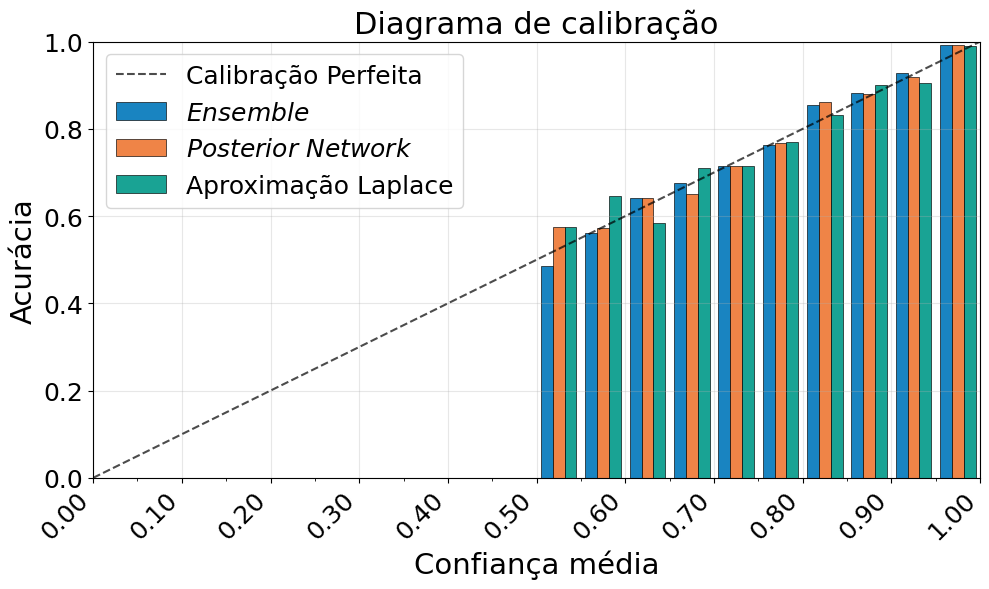

In [130]:
plot_multi_reliability_diagram(
        all_probabilities=all_probs,
        all_predictions_correct=all_correct,
        model_names=names,
        colors=colors,
        alpha=alpha,
        title="Diagrama de calibração",
        save_path = save_path
    )

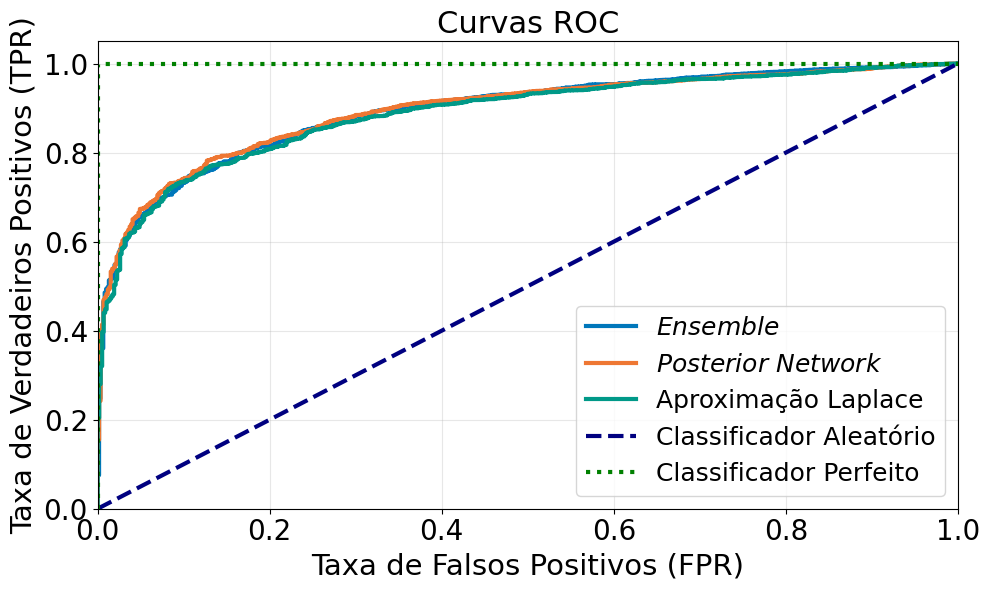

In [120]:
plot_multi_roc_curve(all_probs, all_correct, names, colors, save_path = save_path, show_auc = False)

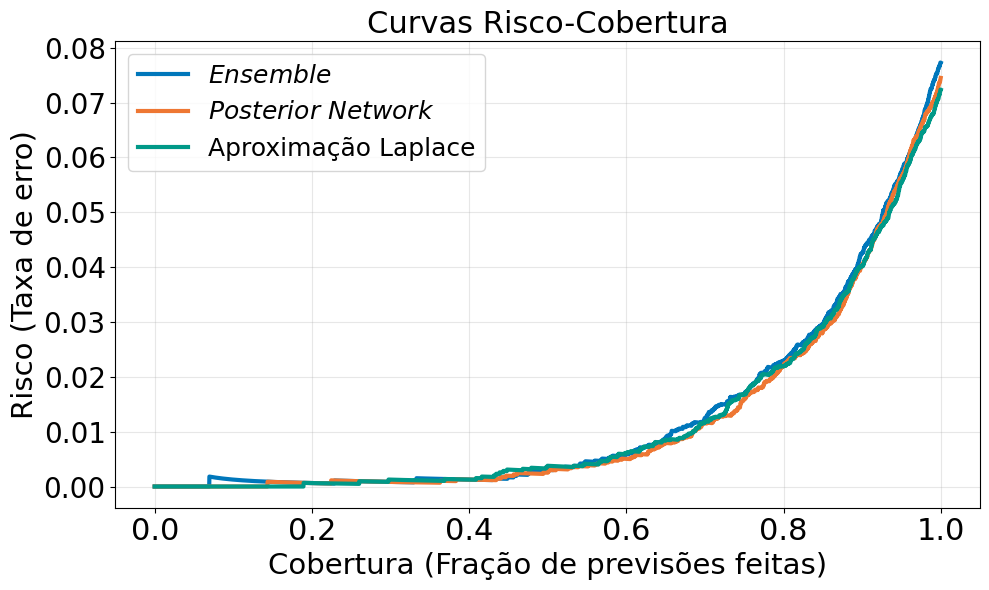

In [118]:
plot_multi_risk_coverage_curve(all_probs, all_correct, names, colors, save_path = save_path,show_auc = False)

In [129]:
def formatar_tabela_latex(post_results, laplace_results, ensemble_results):
    """
    Formata e gera o código de uma tabela em LaTeX com os resultados de ECE, AUROC e AURC
    para os modelos Posterior Network, Aproximação de Laplace e Ensemble.

    Args:
        post_results (dict): Dicionário contendo as métricas para o modelo Posterior Network.
                             Deve conter as chaves 'ECE', 'AUROC' e 'AURC'.
        laplace_results (dict): Dicionário contendo as métricas para o modelo de Aproximação de Laplace.
                                Deve conter as chaves 'ECE', 'AUROC' e 'AURC'.
        ensemble_results (dict): Dicionário contendo as métricas para o modelo Ensemble.
                                 Deve conter as chaves 'ECE_logit', 'AUROC_logit' e 'AURC_logit'.

    Returns:
        str: Uma string contendo o código da tabela formatada em LaTeX.
    """
    # Usar f-strings para criar o template da tabela.
    # O uso do pacote 'booktabs' do LaTeX (\toprule, \midrule, \bottomrule) é recomendado para uma aparência profissional.
    # A formatação dos números de ponto flutuante (ex: :.4f) garante que todos tenham 4 casas decimais.
    tabela_latex = f"""
\\begin{{table}}[ht]
\\centering
\\caption{{Comparação de Métricas de Calibração e Desempenho}}
\\label{{tab:resultados_metricas}}
\\begin{{tabular}}{{lccc}}
\\toprule
\\textbf{{Modelo}} & \\textbf{{ECE}} & \\textbf{{AUROC}} & \\textbf{{AURC}} \\\\
\\midrule
Posterior Network & {post_results['ECE']:.4f} & {post_results['AUROC']:.4f} & {post_results['AURC']:.4f} \\\\
Aproximação de Laplace & {laplace_results['ECE']:.4f} & {laplace_results['AUROC']:.4f} & {laplace_results['AURC']:.4f} \\\\
Ensemble & {ensemble_results['ECE_logit']:.4f} & {ensemble_results['AUROC_logit']:.4f} & {ensemble_results['AURC_logit']:.4f} \\\\
\\bottomrule
\\end{{tabular}}
\\end{{table}}
"""
    return tabela_latex.strip()

# --- Exemplo de Uso ---
# Definição de dicionários com valores de exemplo para demonstração.
# Substitua estes valores 

# Gerar o código LaTeX da tabela
codigo_latex_gerado = formatar_tabela_latex(post_results, laplace_results, ensemble_results)

# Imprimir o código gerado
print(codigo_latex_gerado)

\begin{table}[ht]
\centering
\caption{Comparação de Métricas de Calibração e Desempenho}
\label{tab:resultados_metricas}
\begin{tabular}{lccc}
\toprule
\textbf{Modelo} & \textbf{ECE} & \textbf{AUROC} & \textbf{AURC} \\
\midrule
Posterior Network & 0.0004 & 0.8953 & 0.0118 \\
Aproximação de Laplace & 0.0003 & 0.8883 & 0.0120 \\
Ensemble & 0.0021 & 0.8940 & 0.0126 \\
\bottomrule
\end{tabular}
\end{table}
